<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

### Import Modules & Read Yelp Data

In [121]:
# Standard Library
import re
import string

# DS Classics
import pandas as pd
import numpy as np

# NLP
import spacy
import gensim
nlp = spacy.load("en_core_web_sm")
from gensim import corpora
from gensim.utils import file_or_filename, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

# Models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import SGDClassifier

# Visualization
import matplotlib.pyplot as plt
import squarify
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [122]:
yelp = pd.read_json('./data/review_sample.json', lines=True)

In [123]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [124]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
business_id    10000 non-null object
cool           10000 non-null int64
date           10000 non-null datetime64[ns]
funny          10000 non-null int64
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
useful         10000 non-null int64
user_id        10000 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 703.2+ KB


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [125]:
def tokenize(text):
    """
    Given a document (str) return a list of lemmatized tokens.

    Parameters:
    ----------------
    text (str): text data - could be a DataFrame column

    Returns:
    ----------------
    lemma (list[str]): list of lemmatized tokens
    """
    doc = nlp(text)
    lemma = [token.lemma_.lower() for token in doc if (token.is_stop == False)\
             and (token.is_punct != True)\
             and (token.lemma_ != '-PRON-')]

    return lemma

In [126]:
tokenize("This is data science and we preprocess our text.")

['data', 'science', 'preprocess', 'text']

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [127]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)

# Create vocabulary & calculate word counts
dtm = tfidf.fit_transform(yelp.text)

dtm_df = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm_df.head()

,00,000,00am,00pm,01,04,05,06,07,08,...,zoo,zucchini,zumba,zuzana,ça,équipe,érable,était,été,être
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [129]:
query = tfidf.transform(["This is the best place I've ever spent money. I'm very happy. I'll be returning here again."])
nn.kneighbors(query.todense(), n_neighbors=10)

(array([[1.        , 1.        , 1.16356972, 1.21763305, 1.23601907,
         1.24980635, 1.26282624, 1.26765458, 1.27378848, 1.27690715]]),
 array([[6311, 6204, 5129, 1184,  703, 8540, 5189, 6328, 7896, 9175]]))

In [130]:
dtm_df.loc[703].sort_values(ascending=False)[:20]

happy          0.411046
hour           0.323276
pm             0.301925
early          0.267734
trek           0.200430
summerlin      0.186873
tons           0.158693
ve             0.158637
nearby         0.158351
range          0.157025
stuffed        0.152561
multiple       0.149209
choices        0.142381
heard          0.136319
50             0.130744
recommended    0.130499
glad           0.128960
las            0.128616
late           0.127943
drive          0.125404
Name: 703, dtype: float64

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [131]:
len(yelp)

10000

In [132]:
# Create train and test splits
X_train = yelp['text'][:8000]
X_test = yelp['text'][2000:]
y_train = yelp['stars'][:8000]
y_test = yelp['stars'][2000:]

In [133]:
# Create pipeline
vect = TfidfVectorizer(stop_words='english')
sgdc = SGDClassifier()

pipe = Pipeline([('vect', vect),
                 ('clf', sgdc)])

# Optimize the hyperparams with GridSearch
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__strip_accents': (None, 'ascii'),
    'clf__loss': ('hinge', 'log', 'perceptron'),
    'clf__max_iter': (10, 20, 100, 200),
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)

In [134]:
# Fit grid search and assign best model
grid_search.fit(X_train, y_train)
best = grid_search.best_estimator_
best.score(X_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.8min finished
/home/joseph/miniconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.744125

In [153]:
# Predict star rating for fake review
good_review = ["This is the best place I've ever spent money. I'm very happy. I'll be returning here again."]
bad_review = ['WORST PLACE! BAD SERVICE! I\'LL NEVER COME HERE AGAIN.']

print('Stars predicted for good_review: ', best.predict(good_review)[0])
print('Stars predicted for bad_review: ', best.predict(bad_review)[0])

Stars predicted for good_review:  5
Stars predicted for bad_review:  1


## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [135]:
yelp['tokens'] = yelp['text'].apply(tokenize)
yelp['tokens'].head()

0    [beware, fake, fake, fake, small, business, lo...
1    [come, lunch, togo, service, quick, staff, fri...
2    [vegas, dozen, time, step, foot, circus, circu...
3    [go, night, close, street, party, good, actual...
4    [3.5, 4, star, \n\n, bad, price, $, 12.99, lun...
Name: tokens, dtype: object

In [136]:
# Create id2word parameter for LdaMulticore model
id2word = corpora.Dictionary(yelp['tokens'])
print(len(id2word), len(id2word.keys()))
print(id2word)

24780 24780
Dictionary(24780 unique tokens: [' ', '$', '20', '273', '70']...)


In [137]:
# Remove extremes and create corpus param for LdaMulticore
id2word.filter_extremes(no_below=10, no_above=0.75)

# BoW representation of corpus
corpus = [id2word.doc2bow(text) for text in yelp['tokens']]

In [138]:
corpus[0][::10]

[(0, 4), (10, 1), (20, 1), (30, 1)]

In [139]:
# LDA model
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   num_topics=7,
                   passes=10,
                   workers=4)

In [140]:
lda.print_topics()

[(0,
  '0.013*"time" + 0.011*"service" + 0.011*"great" + 0.011*"good" + 0.011*"\n\n" + 0.010*"work" + 0.010*"go" + 0.009*"come" + 0.009*"place" + 0.008*"recommend"'),
 (1,
  '0.238*" " + 0.014*"good" + 0.010*"\n\n" + 0.009*" \n\n" + 0.009*"food" + 0.009*"place" + 0.008*"great" + 0.007*"  " + 0.007*"like" + 0.006*"time"'),
 (2,
  '0.025*"pizza" + 0.013*"order" + 0.012*"place" + 0.011*"$" + 0.010*"\n" + 0.010*"come" + 0.009*"ask" + 0.008*"like" + 0.008*" " + 0.008*"kid"'),
 (3,
  '0.020*"\n\n" + 0.014*"room" + 0.011*"time" + 0.009*"get" + 0.008*"say" + 0.008*"go" + 0.008*"\n" + 0.008*"tell" + 0.007*"service" + 0.007*"wait"'),
 (4,
  '0.023*"great" + 0.022*"service" + 0.020*"place" + 0.018*"food" + 0.018*" " + 0.012*"store" + 0.011*"come" + 0.011*"time" + 0.009*"like" + 0.009*"amazing"'),
 (5,
  '0.022*"good" + 0.022*"food" + 0.017*"order" + 0.016*"\n\n" + 0.012*"come" + 0.012*"\n" + 0.012*"place" + 0.010*"like" + 0.009*"chicken" + 0.009*"time"'),
 (6,
  '0.038*"\n\n" + 0.017*"place" + 0.

In [141]:
# Topic distance vis. using pyLDAvis
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/home/joseph/miniconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.118051  0.055522       1        1  27.299408
6     -0.088378  0.008962       2        1  18.861214
3      0.117629 -0.008749       3        1  17.903646
0      0.137039 -0.044323       4        1  15.872871
1     -0.079480 -0.055542       5        1   9.897990
4     -0.032091 -0.075875       6        1   5.568655
2      0.063333  0.120004       7        1   4.596215, topic_info=     Category          Freq      Term         Total  loglift  logprob
0     Default  12514.000000            12514.000000  30.0000  30.0000
133   Default   5022.000000      food   5022.000000  29.0000  29.0000
185   Default   4331.000000     great   4331.000000  28.0000  28.0000
332   Default    754.000000     pizza    754.000000  27.0000  27.0000
119   Default   5269.000000     place   5269.000000  26.0000  26.0000
44    Default   3829.000000   service   3829.000000  25.0000  25.0000
326   Default   3446.000000     order   3446.000000  24.0000  24.0000
95    Default   1290.000000      room   1290.000000  23.0000  23.0000
628   Default    851.000000     store    851.000000  22.0000  22.0000
36    Default   3954.000000      come   3954.000000  21.0000  21.0000
48    Default   8638.000000      \n\n   8638.000000  20.0000  20.0000
285   Default   3213.000000        \n   3213.000000  19.0000  19.0000
359   Default   1506.000000       ask   1506.000000  18.0000  18.0000
1     Default   2247.000000         $   2247.000000  17.0000  17.0000
29    Default   1589.000000       say   1589.000000  16.0000  16.0000
39    Default   6325.000000      good   6325.000000  15.0000  15.0000
852   Default    527.000000      \n\n    527.000000  14.0000  14.0000
33    Default   4376.000000      time   4376.000000  13.0000  13.0000
174   Default   1384.000000   amazing   1384.000000  12.0000  12.0000
131   Default   1542.000000       eat   1542.000000  11.0000  11.0000
375   Default   1137.000000  customer   1137.000000  10.0000  10.0000
1331  Default    560.000000     hotel    560.000000   9.0000   9.0000
941   Default   1435.000000   chicken   1435.000000   8.0000   8.0000
216   Default    671.000000      meat    671.000000   7.0000   7.0000
17    Default   3777.000000      like   3777.000000   6.0000   6.0000
639   Default    719.000000       car    719.000000   5.0000   5.0000
310   Default   1625.000000      find   1625.000000   4.0000   4.0000
576   Default   2238.000000      love   2238.000000   3.0000   3.0000
106   Default    992.000000      year    992.000000   2.0000   2.0000
283   Default   1516.000000      work   1516.000000   1.0000   1.0000
...       ...           ...       ...           ...      ...      ...
297    Topic7     55.797756     crust    123.814682   2.2829  -5.9637
359    Topic7    200.231125       ask   1506.326050   1.0620  -4.6860
1      Topic7    231.780334         $   2247.697266   0.8081  -4.5397
326    Topic7    272.724213     order   3446.590332   0.5433  -4.3770
186    Topic7     82.192604      hair    383.706512   1.5391  -5.5764
29     Topic7    161.292618       say   1589.985718   0.7917  -4.9022
874    Topic7     43.631409       gel    117.750984   2.0871  -6.2097
285    Topic7    220.385880        \n   3213.335449   0.4003  -4.5901
119    Topic7    271.032440     place   5269.192871   0.1125  -4.3832
36     Topic7    215.166519      come   3954.826904   0.1687  -4.6140
355    Topic7    116.841728         2   1085.316528   0.8511  -5.2246
35     Topic7    141.758102      wait   1720.135742   0.5839  -5.0313
24     Topic7    112.601990    minute   1099.792969   0.8009  -5.2616
17     Topic7    181.734283      like   3777.917480   0.0456  -4.7829
72     Topic7    146.669220        go   3143.125488   0.0151  -4.9973
149    Topic7     97.766365      star    991.201538   0.7636  -5.4029
33     Topic7    155.669891      time   4376.796875  -0.2564  -4.9377
133    Topic7    152.406784      food   5

In [142]:
# Select optimal number of topics via gensim CoherenceModel
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = yelp['tokens']
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [143]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        start=2, 
                                                        limit=20, 
                                                        step=2)

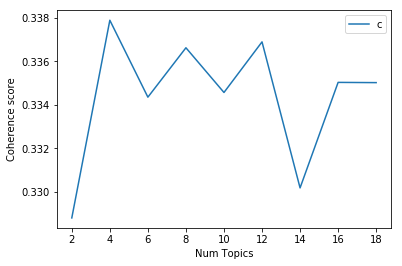

In [144]:
# Graph coherence scores
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [145]:
# Print coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3288
Num Topics = 4  has Coherence Value of 0.3379
Num Topics = 6  has Coherence Value of 0.3344
Num Topics = 8  has Coherence Value of 0.3366
Num Topics = 10  has Coherence Value of 0.3346
Num Topics = 12  has Coherence Value of 0.3369
Num Topics = 14  has Coherence Value of 0.3302
Num Topics = 16  has Coherence Value of 0.335
Num Topics = 18  has Coherence Value of 0.335


### Analysis

This topic modeling analysis would benefit from more preprocessing; The yelp review data requires much more cleaning than out-of-the-box tools can currently offer. A couple glaring examples are 1) the high topical importances of formatting strings such as `\n\n`, multiple occurences of "  ", and 2) the use of multiple languages. I think point two may be highly affective on the model because if the dataset is _mostly_ in English that would make foreign-word vector representations "out of context". Such terms wouldn't have a useful distance from other English words of which the topics consist of. This would explain why foreign words aren't found in the `pyLDAvis` interactive visualization of topics and their most salient terms; Even though those reviews are _likely_ to be discussing the same topics they won't be given much weight _due to the vector representation_. I think that if the foreign language reviews are to be used they need to be preprocessed separately and then recombined with the main data.

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)